# Project 1: Used Vehicle Price Prediction

## Developed by: 
Jorge Luis Madrid Marrugo [jl.madrid@uniandes.edu.co](jl.madrid@uniandes.edu.co)  
Gerson Arturo Guerrero Ramos [ga.guerrero@uniandes.edu.co](ga.guerrero@uniandes.edu.co)

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

## Content  

1. Exploratory Visualization
2. Data Cleaning
3. Feature Engineering
4. Modeling & Evaluation
5. Deploying A Flask RESTPlus API to AWS EC2
6. Things we tried

![](https://github.com/jorgelmadrid/Machine-Learning-Class/raw/master/images/model_process.png)

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
%matplotlib inline 

In [3]:
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

In [4]:
#Lets Read In Train And Test Data
data_train = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data_test = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTest_carListings.zip', index_col=0)
data_train.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


### 1. Exploratory Visualization

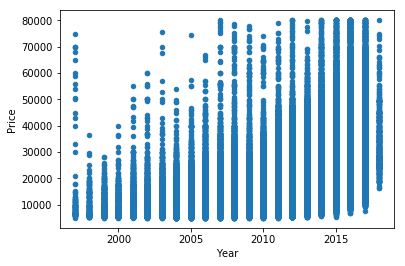

In [5]:
data_train.plot(kind='scatter', y='Price', x='Year')

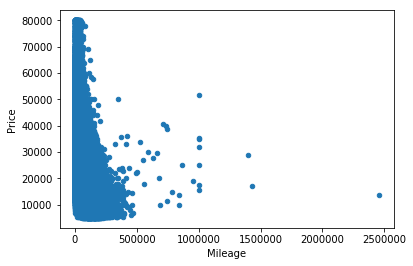

In [6]:
data_train.plot(kind='scatter', y='Price', x='Mileage')

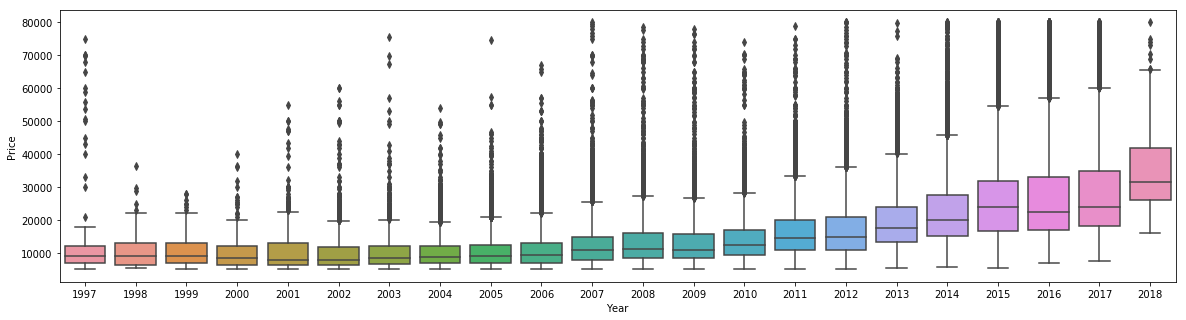

In [7]:
#Price by year
plt.figure(figsize=(20,5))
sns.boxplot(data_train.Year, data_train.Price)

- The price of a car is higher in recent years, as expected

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]), <a list of 38 Text xticklabel objects>)

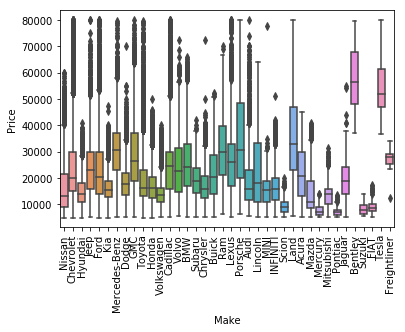

In [8]:
#Price by make
sns.boxplot(data_train.Make, data_train.Price)
plt.xticks(rotation=90)

- Bentley and Tesla are the most expensive car makes

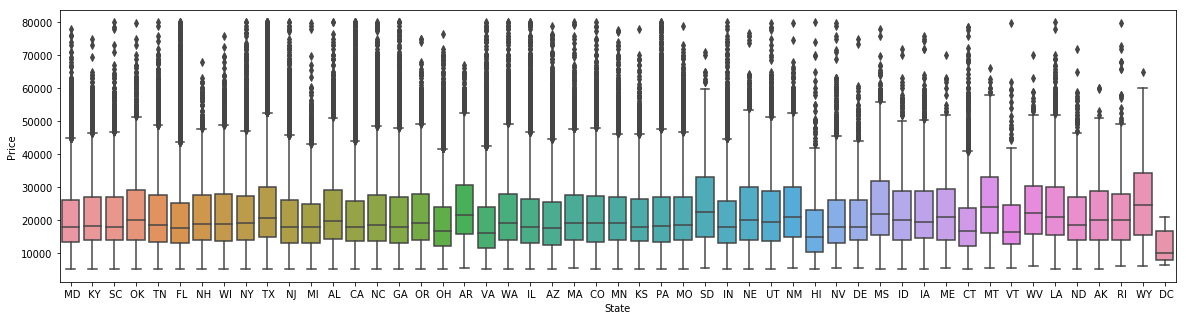

In [9]:
#Price by state
plt.figure(figsize=(20,5))
sns.boxplot(data_train.State, data_train.Price)

- DC has the cheaper car price
- AR and SD are the most expensive states to buy a car

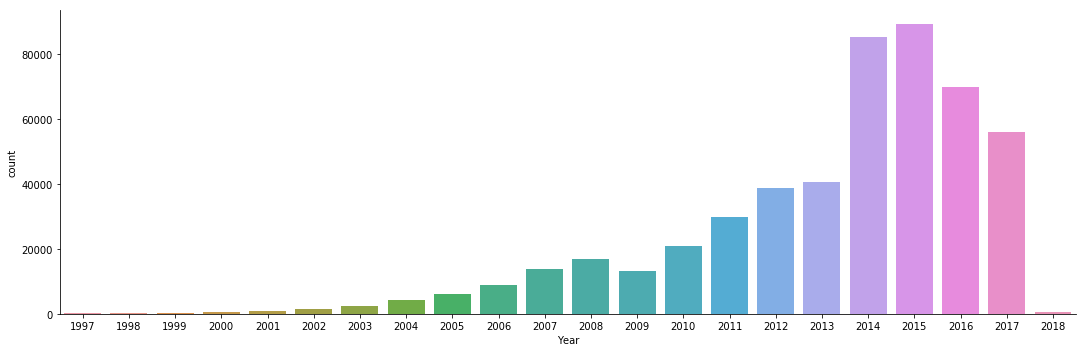

In [10]:
#Numbers of car by year
sns.catplot(x='Year', data=data_train, kind='count', height=5, aspect=3)

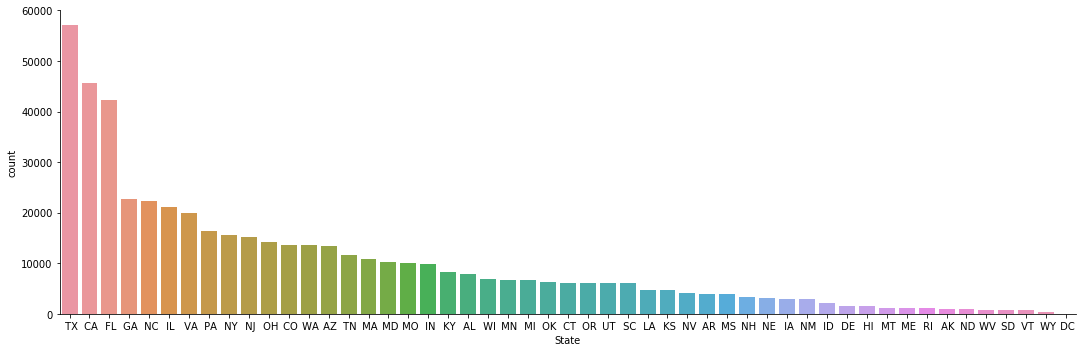

In [11]:
#Numbers of car by state 
sns.catplot(x='State', data=data_train, kind='count', height=5, aspect=3, order = data_train['State'].value_counts().index)

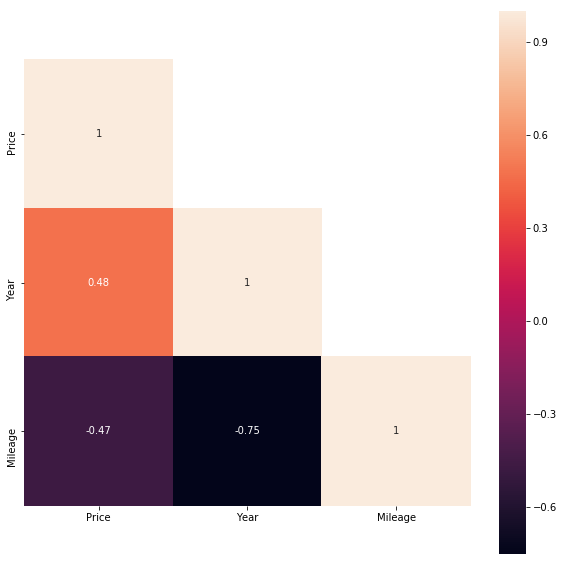

In [12]:
#correlation matrix
cor_mat= data_train[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(10,10)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

- As the car mileage increases, its price decreases, as expected
- As the car year increases, its price increases too. A newer car will be more expensive.

In [13]:
#descriptive statistics
data_train.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

### 2. Data Cleaning

In [14]:
data_train.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

In [15]:
#checking for dtypes, non-null values and memory usage
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
Price      500000 non-null int64
Year       500000 non-null int64
Mileage    500000 non-null int64
State      500000 non-null object
Make       500000 non-null object
Model      500000 non-null object
dtypes: int64(3), object(3)
memory usage: 22.9+ MB


In [16]:
#checking for missing values
data_train.isnull().sum()

Price      0
Year       0
Mileage    0
State      0
Make       0
Model      0
dtype: int64

### 3. Feature Engineering

In [5]:
import category_encoders as ce

#Encoding variables with binary encoded
X = data_train.drop('Price',axis=1)
y = data_train['Price']

encoder = ce.BinaryEncoder()
encoder.fit(X,y)

BinaryEncoder(cols=['State', 'Make', 'Model'], drop_invariant=False,
       handle_unknown='impute', impute_missing=True, return_df=True,
       verbose=0)

In [7]:
#Encoder use to decode in the api
from sklearn.externals import joblib
filename = 'encoder_to_aws.sav'
joblib.dump(encoder, filename)

['encoder_to_aws.sav']

In [8]:
#Creating data train and test encoded
X_train_encoded = encoder.transform(X)
X_test_encoded = encoder.transform(data_test)

In [9]:
X_train_encoded.sample(5)

,State_0,State_1,State_2,State_3,State_4,State_5,State_6,Make_0,Make_1,Make_2,...,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Year,Mileage
47315,0,0,0,1,1,1,0,0,0,0,...,0,0,1,0,1,0,0,1,2011,97179
306106,0,0,0,0,1,1,0,0,0,0,...,0,0,1,1,1,0,1,1,2013,96349
199363,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,2011,116362
238962,0,0,1,0,0,0,1,0,0,1,...,1,0,1,1,0,1,1,0,2012,72937
88822,0,0,0,1,1,1,0,0,0,1,...,0,0,1,1,1,1,0,0,2015,41559


In [10]:

#Log-transform the response variable
ylog = np.log1p(y)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10afd4cc0>,
      dtype=object)

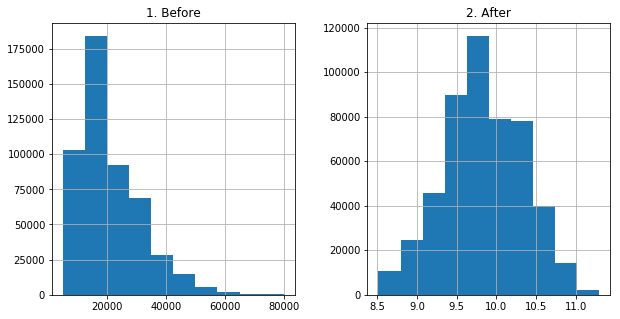

In [21]:
#Check the transformation
matplotlib.rcParams['figure.figsize'] = (10, 5)
prices = pd.DataFrame({"1. Before": y, "2. After":ylog})
prices.hist()

### 4. Modeling & Evaluation

In [22]:
#evaluate different models
models = [RandomForestRegressor(), GradientBoostingRegressor(), AdaBoostRegressor(), BaggingRegressor()]
model_names = ['RandomForestRegressor', 'GradientBoostingRegressor', 'AdaBoostRegressor', 'BaggingRegressor']

rmsle=[]

for model in range (len(models)):
    clf=models[model]
    clf.fit(X, ylog)
    y_pred = clf.predict(X)
    rmsle.append(np.sqrt(mean_squared_log_error(np.exp(ylog),np.exp(y_pred))))

In [23]:
d={'Model':model_names,'RMSLE':rmsle}   
rmsle_frame=pd.DataFrame(d).sort_values('RMSLE')
rmsle_frame

,Model,RMSLE
0,RandomForestRegressor,0.067152
3,BaggingRegressor,0.067352
1,GradientBoostingRegressor,0.252500
2,AdaBoostRegressor,0.386630


In [ ]:
#Tunning RandomForest

#N_estimators

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestRegressor(n_estimators=estimator, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    mse = mean_squared_error(y_train, train_pred)
    train_results.append(mse)
    
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    test_results.append(mse)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train MSE")
line2, = plt.plot(n_estimators, test_results, 'r', label='Test MSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('MSE score')
plt.xlabel('n_estimators')
plt.show()

![Loco](https://github.com/jorgelmadrid/Machine-Learning-Class/raw/master/images/n_estimators_tunning.png)

In [ ]:
# Tunning max depth

max_depths = np.linspace(30, 40, 11, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
    rf = RandomForestRegressor(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    mse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_results.append(mse)
    
    y_pred = rf.predict(X_test)
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_results.append(mse)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train RMSE")
line2, = plt.plot(max_depths, test_results, 'r', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('max_depth')
plt.show()

![](https://github.com/jorgelmadrid/Machine-Learning-Class/raw/master/images/max_deptn_tunning.png)

In [ ]:
rmse_metrics=[]
min_rmse=20000; min_rmse_comb={}
for n_estimator in range(1,35):
    for feature in range(1,1+X_train_encoded.shape[1]):
        for depth in range(1,40):
            
            rforest_reeg = RandomForestRegressor(n_estimators=n_estimator, max_depth = depth, max_features=feature, random_state=1, n_jobs=-1)
            rforest_reeg.fit(X_train_encoded, y_train)
            y_train_pred = rforest_reeg.predict(X_train_encoded)
            
            rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
            
            if min_rmse > rmse :
                min_rmse = rmse
                min_rmse_comb = {'n_estimators':n_estimator, 'max_features':feature, 'max_depth':depth, 'rmse':rmse}
                print(min_rmse_comb)
                
            rmse_metrics.append((n_estimator,feature,depth,rmse))
            

In [ ]:
{'n_estimators': 2, 'max_features': 1, 'max_depth': 25, 'rmse': 2709.657447469052}
{'n_estimators': 2, 'max_features': 1, 'max_depth': 26, 'rmse': 2677.997430922424}
{'n_estimators': 2, 'max_features': 1, 'max_depth': 27, 'rmse': 2649.797019232938}
{'n_estimators': 2, 'max_features': 1, 'max_depth': 28, 'rmse': 2611.537094355072}
{'n_estimators': 2, 'max_features': 1, 'max_depth': 30, 'rmse': 2600.8560857140787}
{'n_estimators': 2, 'max_features': 1, 'max_depth': 32, 'rmse': 2568.387021328777}
:
:
:
{'n_estimators': 12, 'max_features': 11, 'max_depth': 36, 'rmse': 1591.2850507898972}
{'n_estimators': 12, 'max_features': 11, 'max_depth': 37, 'rmse': 1588.6486304254463}
{'n_estimators': 12, 'max_features': 14, 'max_depth': 36, 'rmse': 1586.1715412353974}
{'n_estimators': 12, 'max_features': 16, 'max_depth': 38, 'rmse': 1584.2953785770444}


In [ ]:
#Random forest 1

rfModel = RandomForestRegressor(n_estimators=300, max_depth=45, max_features=22, random_state=111, n_jobs=-1)
rfModel.fit(X_train_encoded,y)
preds=rfModel.predict(X_train_encoded)
np.sqrt(mean_squared_error(y,preds))

#1381.53197944593 n_estimators=300, max_depth=45, max_features=22, random_state=111, n_jobs=-1

In [ ]:
kaggle_preds = rfModel.predict(X_test_encoded)
kaggle_pred_dict = {'RForest_1_NE_300_MD_45_MF_22':kaggle_preds}
kaggle_pred_df_bag = pd.DataFrame.from_dict(kaggle_pred_dict)
#np.sqrt(mean_squared_error(y_data_full,Full_pred))

In [15]:
kaggle_pred_df_bag.head()

,RForest_1_NE_300_MD_45_MF_22
0,16295.096667
1,16628.086667
2,8569.616667
3,34419.710000
4,10351.996667


In [ ]:
#Random forest 2

rfModel = RandomForestRegressor(n_estimators=500, max_depth=38, max_features=16, random_state=111, n_jobs=-1)
rfModel.fit(X_train_encoded,y)
preds=rfModel.predict(X_train_encoded)
np.sqrt(mean_squared_error(y,preds))

#improve a little
#1389.4948457259125 - 200 estimators, MD=38, MF=16
#1381.5695314508007 - 500 est, MD=38, MF=16
#1385.9858864147104 - 200 est, MD=43, MF=18
#1378.3583691227805 n_estimators=500, max_depth=43, max_features=22, random_state=111, n_jobs=-1)

In [ ]:
#kaggle_pred_dict = {'RForest_1_NE_500_MD_38_MF_16':kaggle_preds}
kaggle_pred_df_bag.loc[:,'RForest_1_NE_500_MD_38_MF_16'] = rfModel.predict(X_test_encoded)
#np.sqrt(mean_squared_error(y_data_full,Full_pred))

In [17]:
kaggle_pred_df_bag[['RForest_1_NE_300_MD_45_MF_22','RForest_1_NE_500_MD_38_MF_16']].head()

,RForest_1_NE_300_MD_45_MF_22,RForest_1_NE_500_MD_38_MF_16
0,16295.096667,16337.332
1,16628.086667,16714.688
2,8569.616667,8378.774
3,34419.710000,34746.644
4,10351.996667,9977.728


In [ ]:

#Random forest 3

rfModel = RandomForestRegressor(n_estimators=100, max_depth=38, max_features=16, random_state=111, n_jobs=-1)
rfModel.fit(X_train_encoded,y)
preds=rfModel.predict(X_train_encoded)
np.sqrt(mean_squared_error(y,preds))

In [ ]:
kaggle_pred_df_bag.loc[:,'RForest_1_NE_100_MD_38_MF_16'] = rfModel.predict(X_test_encoded)

In [18]:
kaggle_pred_df_bag.head()

,RForest_1_NE_300_MD_45_MF_22,RForest_1_NE_500_MD_38_MF_16,RForest_1_NE_100_MD_38_MF_16
0,16295.096667,16337.332,16402.21
1,16628.086667,16714.688,16611.49
2,8569.616667,8378.774,8211.92
3,34419.710000,34746.644,34541.72
4,10351.996667,9977.728,10280.83


In [19]:
kaggle_pred_df_mean = kaggle_pred_df_bag.mean(axis=1)
kaggle_pred_df_mean= pd.DataFrame(kaggle_pred_df_mean)
kaggle_pred_df_mean.columns=['Price']
kaggle_pred_df_mean.head()

,Price
0,16344.879556
1,16651.421556
2,8386.770222
3,34569.358000
4,10203.518222


#### Submission on kaggle

In [ ]:
kaggle_pred_df_mean.to_csv('1.RForest_Bag_20180311_0217.csv',index_label='ID')

![](https://github.com/jorgelmadrid/Machine-Learning-Class/raw/master/images/aws_ec2.png)

### 5. Deploying A Flask RESTPlus API to AWS EC2

#### 5.1. Save the model

In [27]:
from sklearn.externals import joblib
joblib.dump(rfModel, 'api/rfModel.pkl', compress=3)

['api/rfModel.pkl']

#### 5.2. Model in batch

In [28]:
from api.model_deployment import predict_price

In [29]:
predict_price(2016, 24633, 'SC', 'Hyundai', 'Santa')

array([26097.6])

#### 5.3. API

Load Flask

In [30]:
from flask import Flask
from flask_restplus import Api, Resource, fields
from sklearn.externals import joblib

Create API

In [31]:
app = Flask(__name__)

api = Api(
    app, 
    version='1.0', 
    title='Car Price Prediction API',
    description='Car Price Prediction API')

#name space (/orders)
ns = api.namespace('predict', 
     description='Car Price Prediction')

#Para leer datos
parser = api.parser()

parser.add_argument(
    'Year', 
    type=int, 
    required=True, 
    help='Year', 
    location='args')

parser.add_argument(
    'Mileage', 
    type=int, 
    required=True, 
    help='Mileage', 
    location='args')

parser.add_argument(
    'State', 
    type=str, 
    required=True, 
    help='State', 
    location='args')

parser.add_argument(
    'Make', 
    type=str, 
    required=True, 
    help='Make', 
    location='args')

parser.add_argument(
    'Model', 
    type=str, 
    required=True, 
    help='Model', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})

Load model and create function that predicts vehicle prices

In [ ]:
from api.model_deployment import predict_price

In [32]:
@ns.route('/')
class PricingApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": predict_price(args['Year'], args['Mileage'], args['State'], args['Make'], args['Model'])
        }, 200

Run API

In [33]:
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [10/Mar/2019 21:18:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Mar/2019 21:18:52] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [10/Mar/2019 21:18:52] "GET /swaggerui/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [10/Mar/2019 21:18:52] "GET /swaggerui/droid-sans.css HTTP/1.1" 304 -
127.0.0.1 - - [10/Mar/2019 21:18:53] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [10/Mar/2019 21:18:54] "GET /swagger.json HTTP/1.1" 200 -


Check the API

http://18.221.140.44:8888/predict/?Year=2015&Mileage=25741&State=%27KY%27&Make=%27Chevrolet%27&Model=%27CamaroCoupe%27

![](https://github.com/jorgelmadrid/Machine-Learning-Class/raw/master/images/P1API.png)

### 6. Thing we tried

We trying to encoded variables, to avoid make more features than dummies methods, this implementation didn't have a good approach

In [ ]:
########
# This section was a try - It doesn't fix
#######

# Encode categorical columns and coerce to category type for train and test
datasets = [data_train, data_test]
to_enconde = ['State', 'Make', 'Model']

le = LabelEncoder()
for i in datasets:
    for j in to_enconde:
        le.fit(i[j])
        i[j] = le.transform(i[j])
        i[j] = i[j].astype("category")

We trying to rewrite price, like a price range, and estimate with the mean of the range. This transformation doesn't fix the RMSE

In [21]:
#Making Price ranges
data_train['Price_rank']=pd.cut(data_train['Price'],100,labels=False)
ptable_q=pd.pivot_table(data_train, values='Price', index=['Price_rank'],aggfunc=[np.min,np.max,np.mean])
ptable_q.columns=['minPrice','maxPrice','meanPrice']
#ptable_q.sample(5)
data_train = data_train.merge(ptable_q, left_on='Price_rank', right_on='Price_rank')
data_train = data_train.drop(['Price','Price_rank','minPrice','maxPrice'],axis=1)
data_train['meanPrice'] = data_train.loc[:,'meanPrice'].apply(lambda x:int(x))

In [ ]:
#Random forest 4

X = data_train.drop('meanPrice',axis=1)
y = data_train['meanPrice']
encoder = ce.BinaryEncoder()#.fit_transform(X_train)
encoder.fit(X,y)
X_train_encoded = encoder.transform(X)


rfModel = RandomForestRegressor(n_estimators=300, max_depth=38, max_features=18, random_state=111, n_jobs=-1)
rfModel.fit(X_train_encoded,y)
preds=rfModel.predict(X_train_encoded)
np.sqrt(mean_squared_error(y,preds))

1383.5856701777755

We detect a behavior in the dataset, we found some missing values, some vehicles doesn't have price in some years, we tried to fill out with the mean by vehicle

In [22]:

pivot_price = pd.pivot_table(data_train, values='meanPrice', index=['Make','Model','State','Mileage'], columns=['Year'],aggfunc=[np.mean])
pivot_price.head(10)


mean                                              \
Year                       1997 1998 1999 2000     2001 2002 2003 2004 2005   
Make  Model  State Mileage                                                    
Acura MDX4WD  AK   119079   NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN  NaN   
                   125764   NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN  NaN   
              AL   97343    NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN  NaN   
                   100600   NaN  NaN  NaN  NaN  10811.0  NaN  NaN  NaN  NaN   
                   137920   NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN  NaN   
                   152394   NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN  NaN   
              AR   141276   NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN  NaN   
              AZ   89044    NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN  NaN   
                   119796   NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN  NaN   
                   137461   NaN  NaN  NaN  NaN      NaN  NaN  NaN  NaN  NaN   

                                ...                                           \
Year                       2006 ...  2009 2010 2011 2012 2013 2014 2015 2016   
Make  Model  State Mileage      ...                                            
Acura MDX4WD  AK   119079   NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   125764   NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              AL   97343    NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   100600   NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   137920   NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   152394   NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              AR   141276   NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
              AZ   89044    NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   119796   NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   137461   NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                      
Year                       2017 2018  
Make  Model  State Mileage            
Acura MDX4WD  AK   119079   NaN  NaN  
                   125764   NaN  NaN  
              AL   97343    NaN  NaN  
                   100600   NaN  NaN  
                   137920   NaN  NaN  
                   152394   NaN  NaN  
              AR   141276   NaN  NaN  
              AZ   89044    NaN  NaN  
                   119796   NaN  NaN  
                   137461   NaN  NaN  

[10 rows x 22 columns]

In [29]:
pivot_price = pd.DataFrame(pivot_price.to_records())

In [30]:
pivot_price.head()

,Model,Make,State,Mileage,"('mean', 1997)","('mean', 1998)","('mean', 1999)","('mean', 2000)","('mean', 2001)","('mean', 2002)",...,"('mean', 2009)","('mean', 2010)","('mean', 2011)","('mean', 2012)","('mean', 2013)","('mean', 2014)","('mean', 2015)","('mean', 2016)","('mean', 2017)","('mean', 2018)"
0,MDX4WD,Acura,AK,119079,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MDX4WD,Acura,AK,125764,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MDX4WD,Acura,AL,97343,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MDX4WD,Acura,AL,100600,NaN,NaN,NaN,NaN,10811.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MDX4WD,Acura,AL,137920,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
#pivot_price = pivot_price.set_index('Model')
pivot_price = pivot_price.reset_index()

In [38]:
pivot_price.head()

,Model,Make,State,Mileage,"('mean', 1997)","('mean', 1998)","('mean', 1999)","('mean', 2000)","('mean', 2001)","('mean', 2002)",...,"('mean', 2009)","('mean', 2010)","('mean', 2011)","('mean', 2012)","('mean', 2013)","('mean', 2014)","('mean', 2015)","('mean', 2016)","('mean', 2017)","('mean', 2018)"
0,MDX4WD,Acura,AK,119079,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MDX4WD,Acura,AK,125764,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MDX4WD,Acura,AL,97343,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MDX4WD,Acura,AL,100600,NaN,NaN,NaN,NaN,10811.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MDX4WD,Acura,AL,137920,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
